## **Descarga de Bases**

In [2]:
from google.colab import drive

# Montamos nuestra unidad drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Nos dirigimos a la carpeta con los inputs
%cd /content/drive/My\ Drive/2021-1/TAC/TA

/content/drive/My Drive/2021-1/TAC/TA


###**Imports**

In [62]:
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [63]:
%tensorflow_version 2.x
from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(0)

### **Lectura de imágenes**

In [64]:
#!mkdir data
#!cd data && unzip BSDS300-images.zip

In [65]:
#!ls

In [66]:
srcPath = '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images'

train_scan_paths = os.listdir(srcPath + '/train')
test_scan_paths = os.listdir(srcPath + '/test')

train_scan_paths = [(srcPath + '/train/' + x) for x in train_scan_paths]
test_scan_paths = [(srcPath + '/test/' + x) for x in test_scan_paths]


print("train scan with length of: {}".format(len(train_scan_paths)))
print("test scan with length of: {}".format(len(test_scan_paths)))

train scan with length of: 200
test scan with length of: 100


In [67]:
train_scan_paths[:5]

['/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/train/365025.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/train/20008.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/train/232038.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/train/188091.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/train/286092.jpg']

In [68]:
test_scan_paths[:5]

['/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/test/170057.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/test/163085.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/test/220075.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/test/167062.jpg',
 '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images/test/43074.jpg']

###**Preprocesamiento**

In [69]:
def normalize_scan(image):

  norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  return norm_image

def resize_scan(scan, desired_width, desired_height):
  
  scan = cv2.resize(scan, (desired_height, desired_width))

  return scan

def preprocess_scan(path, width, height):
  scan = cv2.imread(path)
  
  resized_scan = resize_scan(scan, width, height)
  
  normalized_resized_scan = normalize_scan(resized_scan)

  return normalized_resized_scan

def generate_img(image): 
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [70]:
width = 256
height = 256

In [71]:
train_scans = [preprocess_scan(path, width, height) for path in train_scan_paths]
test_scans = [preprocess_scan(path, width, height) for path in test_scan_paths]

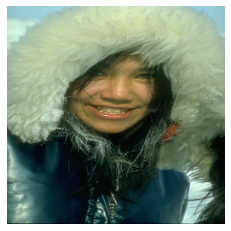

In [72]:
data = train_scans[0]

plt.axis("off")
plt.imshow(cv2.cvtColor(data, cv2.COLOR_BGR2RGB))
plt.show()

In [73]:
data = train_scans[0]

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

noise_img = sp_noise(data,0.05)

In [74]:
image = train_scans[0]

gaussian_noise = np.zeros((image.shape[0], image.shape[1], image.shape[2]),dtype=np.float32)
cv2.randn(gaussian_noise, 0, 255)
gaussian_noise = (gaussian_noise*0.5).astype(np.float32)
noisy_image1 = cv2.add(image,gaussian_noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


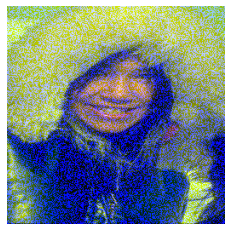

In [75]:
generate_img(noisy_image1)

In [76]:
def noisy(noise_typ,image):
  if noise_typ == "gauss":
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
  elif noise_typ == "s&p":
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    return out
  elif noise_typ == "poisson":
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
  elif noise_typ =="speckle":
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


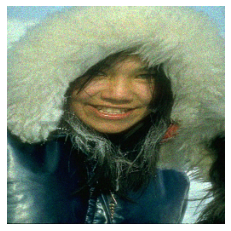

In [77]:
image = train_scans[0]
noisyimg = noisy('poisson', image)
generate_img(noisyimg.astype('float32'))

In [78]:
train_gaussian_noise_images = np.array([noisy('poisson', x) for x in train_scans])
test_gaussian_noise_images = np.array([noisy('poisson', x) for x in test_scans])

train_target_images = np.array(train_scans)
test_target_images = np.array(test_scans)

In [79]:
train_gaussian_noise_images[0]

array([[[0.78125   , 0.71484375, 0.53515625],
        [0.79296875, 0.83203125, 0.65625   ],
        [0.87109375, 0.77734375, 0.62109375],
        ...,
        [0.71875   , 0.81640625, 0.54296875],
        [0.83984375, 0.7734375 , 0.5703125 ],
        [0.76171875, 0.69921875, 0.5078125 ]],

       [[0.7578125 , 0.765625  , 0.50390625],
        [0.80859375, 0.75      , 0.578125  ],
        [0.78515625, 0.82421875, 0.59375   ],
        ...,
        [0.89453125, 0.84765625, 0.5625    ],
        [0.828125  , 0.79296875, 0.4765625 ],
        [0.8359375 , 0.8359375 , 0.5234375 ]],

       [[0.84375   , 0.7578125 , 0.56640625],
        [0.82421875, 0.72265625, 0.55078125],
        [0.7734375 , 0.73046875, 0.56640625],
        ...,
        [0.7890625 , 0.8046875 , 0.578125  ],
        [0.80859375, 0.69921875, 0.51953125],
        [0.76171875, 0.7578125 , 0.57421875]],

       ...,

       [[0.33203125, 0.34765625, 0.1328125 ],
        [0.3515625 , 0.359375  , 0.14453125],
        [0.33203125, 0

In [80]:
# Funcion de perdida - MSE
from tensorflow.keras.losses import MeanSquaredError

mse = tf.keras.losses.MeanSquaredError()
mse(train_gaussian_noise_images[0], train_scans[0].astype(np.float32)).numpy()

0.0016565165

In [96]:
# Batch size
BATCH_SIZE = 10

# Train size
train_gaussian_noise_images.shape[0]

# Epochs number
EPOCHS = (int)(train_gaussian_noise_images.shape[0]/BATCH_SIZE)
print("Numero de epocas: {}".format(EPOCHS))


Numero de epocas: 20


### ***Modelamiento***

In [97]:
from keras import Input, Model
from keras import layers
from keras import backend as K
K.clear_session()

In [98]:
def Autoencoder():
  
  input_img = Input(shape=(256, 256, 3))  

  # ============================================================================
  # == ENCODER
  # ============================================================================

  conv_1_a = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(input_img)
  l_relu_1_a = layers.LeakyReLU()(conv_1_a)
  conv_1_b = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(l_relu_1_a)
  l_relu_1_b = layers.LeakyReLU()(conv_1_b)
  maxpool_1 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_1_b)
  #print(maxpool_1.shape)

  conv_2 = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(maxpool_1)
  l_relu_2 = layers.LeakyReLU()(conv_2)
  maxpool_2 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_2)
  #print(maxpool_2.shape)

  conv_3 = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(maxpool_2)
  l_relu_3 = layers.LeakyReLU()(conv_3)
  maxpool_3 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_3)
  #print(maxpool_3.shape)

  conv_4 = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(maxpool_3)
  l_relu_4 = layers.LeakyReLU()(conv_4)
  maxpool_4 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_4)
  #print(maxpool_4.shape)

  conv_5_a = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(maxpool_4)
  l_relu_5_a = layers.LeakyReLU()(conv_5_a)
  maxpool_5 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_5_a)
  #print(maxpool_5.shape)

  conv_5_b = layers.Conv2D(48, (3, 3), padding='same', use_bias=True)(maxpool_5)
  encoded = layers.LeakyReLU()(conv_5_b)

  # ============================================================================
  # == DECODER
  # ============================================================================

  upsamp_6 = layers.UpSampling2D((2, 2))(encoded)
  #print(upsamp_6.shape)
  concat_6 = tf.concat([upsamp_6, maxpool_4], axis=3)
  #print(concat_6.shape)
  conv_6_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(concat_6)
  l_relu_6_a = layers.LeakyReLU()(conv_6_a)
  conv_6_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(l_relu_6_a)
  l_relu_6_b = layers.LeakyReLU()(conv_6_b)
  
  upsamp_7 = layers.UpSampling2D((2, 2))(l_relu_6_b)
  #print(upsamp_7.shape)
  concat_7 = tf.concat([upsamp_7, maxpool_3], axis=3)
  #print(concat_7.shape)
  conv_7_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(concat_7)
  l_relu_7_a = layers.LeakyReLU()(conv_7_a)
  conv_7_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(l_relu_7_a)
  l_relu_7_b = layers.LeakyReLU()(conv_7_b)

  upsamp_8 = layers.UpSampling2D((2, 2))(l_relu_7_b)
  #print(upsamp_8.shape)
  concat_8 = tf.concat([upsamp_8, maxpool_2], axis=3)
  #print(concat_8.shape)
  conv_8_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(concat_8)
  l_relu_8_a = layers.LeakyReLU()(conv_8_a)
  conv_8_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(l_relu_8_a)
  l_relu_8_b = layers.LeakyReLU()(conv_8_b)

  upsamp_9 = layers.UpSampling2D((2, 2))(l_relu_8_b)
  #print(upsamp_9.shape)
  concat_9 = tf.concat([upsamp_9, maxpool_1], axis=3)
  #print(concat_9.shape)
  conv_9_a = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(concat_9)
  l_relu_9_a = layers.LeakyReLU()(conv_9_a)
  conv_9_b = layers.Conv2D(96, (3, 3), padding='same', use_bias=True)(l_relu_9_a)
  l_relu_9_b = layers.LeakyReLU()(conv_9_b)

  upsamp_10 = layers.UpSampling2D((2, 2))(l_relu_9_b)
  #print(upsamp_10.shape)
  concat_10 = tf.concat([upsamp_10, input_img], axis=3)
  #print(concat_10.shape)
  conv_10_a = layers.Conv2D(64, (3, 3), padding='same', use_bias=True)(concat_10)
  l_relu_10_a = layers.LeakyReLU()(conv_10_a)
  conv_10_b = layers.Conv2D(32, (3, 3), padding='same', use_bias=True)(l_relu_10_a)
  l_relu_10_b = layers.LeakyReLU()(conv_10_b)

  decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_10_b)
  #print(decoded.shape)
  # decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_7_b)

  return Model(input_img, decoded)

In [99]:
autoencoder = Autoencoder()

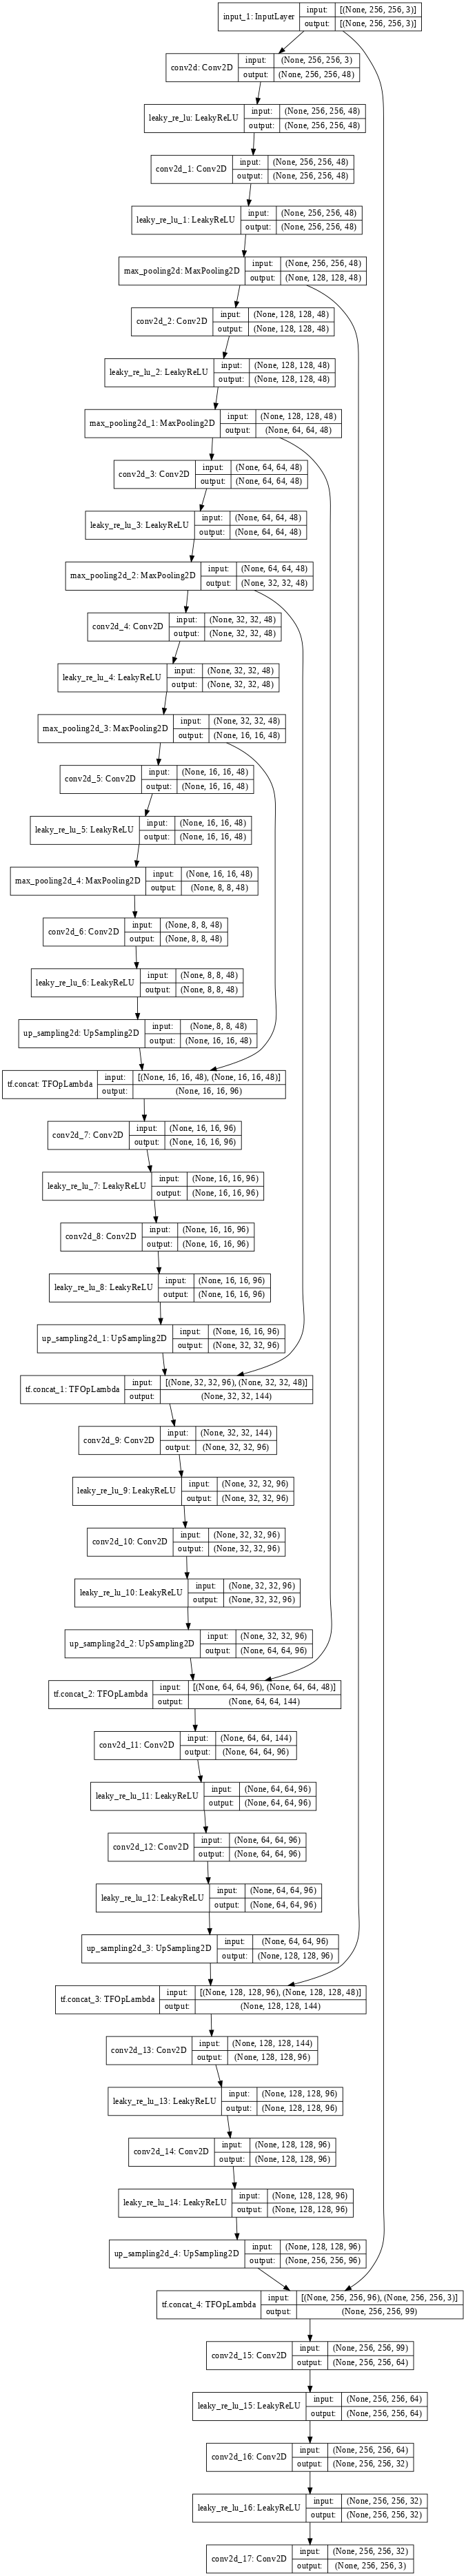

In [100]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, show_shapes=True, dpi=64)

In [101]:
from tensorflow.keras.optimizers import Adam

# Definimos la funcion de optimizacion
autoencoder_optimizer = Adam(0.001, beta_1=0.9)

In [102]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=autoencoder_optimizer,
                                 autoencoder=autoencoder)

### ***Training***

In [103]:
from datetime import datetime
import time
import os

if not os.path.isdir('logs'):
  os.mkdir('logs')

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [104]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as autoencoder_tape:
    autoencoder_output = autoencoder(input_image, training=True)

    mse_loss = mse(autoencoder_output, target)

  autoencoder_gradients = autoencoder_tape.gradient(mse_loss,
                                          autoencoder.trainable_variables)
  autoencoder_optimizer.apply_gradients(zip(autoencoder_gradients,
                                          autoencoder.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('autoencoder_mse_loss', mse_loss, step=epoch)

In [105]:
def fit(train_ds, epochs):
  for epoch in range(epochs):
    start = time.time()

    # display.clear_output(wait=True)

    # for example_input, example_target in test_ds.take(1):
    #   generate_images(generator, example_input, example_target)
    # print("Epoch: ", epoch)

    # Training step
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # Saving (checkpointing) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

In [106]:
train_tuple = list(zip(train_target_images, train_target_images))

In [107]:
from tensorflow.data import Dataset

ds_train_images = Dataset.from_tensor_slices(train_gaussian_noise_images)
ds_target_images = Dataset.from_tensor_slices(train_target_images)

train_dataset = Dataset.zip((ds_train_images,ds_target_images))
train_dataset = train_dataset.batch(BATCH_SIZE)

In [108]:
tf.config.run_functions_eagerly(True)

In [109]:
fit(train_dataset, EPOCHS)

....................
Time taken for epoch 1 is 10.77816104888916 sec

....................
Time taken for epoch 2 is 6.438518285751343 sec

....................
Time taken for epoch 3 is 6.412005662918091 sec

....................
Time taken for epoch 4 is 6.350940942764282 sec

....................
Time taken for epoch 5 is 6.316681623458862 sec

....................
Time taken for epoch 6 is 6.273736000061035 sec

....................
Time taken for epoch 7 is 6.247151851654053 sec

....................
Time taken for epoch 8 is 6.250784873962402 sec

....................
Time taken for epoch 9 is 6.243553400039673 sec

....................
Time taken for epoch 10 is 6.228901624679565 sec

....................
Time taken for epoch 11 is 6.2278900146484375 sec

....................
Time taken for epoch 12 is 6.250437498092651 sec

....................
Time taken for epoch 13 is 6.247459411621094 sec

....................
Time taken for epoch 14 is 6.253206729888916 sec

..............

### **Modelling**

In [110]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [111]:
autoencoder.fit(train_gaussian_noise_images, train_target_images,
                epochs=30,
                shuffle=True,
                validation_data=(test_gaussian_noise_images, test_target_images))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
7/7 [==============================] - 7s 1s/step - loss: 0.0352 - val_loss: 0.0277
Epoch 2/30
7/7 [==============================] - 7s 1s/step - loss: 0.0202 - val_loss: 0.0082
Epoch 3/30
7/7 [==============================] - 7s 1s/step - loss: 0.0074 - val_loss: 0.0053
Epoch 4/30
7/7 [==============================] - 7s 1s/step - loss: 0.0049 - val_loss: 0.0028
Epoch 5/30
7/7 [==============================] - 7s 1s/step - loss: 0.0029 - val_loss: 0.0024
Epoch 6/30
7/7 [==============================] - 7s 1s/step - loss: 0.0024 - val_loss: 0.0018
Epoch 7/30
7/7 [==============================] - 7s 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/30
7/7 [==============================] - 7s 1s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/30
7/7 [==============================] - 7s 1s/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/30
7/7 [==============================] - 7s 1s/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/30
7/7 [==============================] 

### **Testing**

In [112]:
ds_test_images = Dataset.from_tensor_slices(test_gaussian_noise_images)
ds_test_target_images = Dataset.from_tensor_slices(test_target_images)

test_dataset = Dataset.zip((ds_test_images,ds_test_target_images))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [114]:
def generate_images(model, test_input, tar):
  prediction = model.predict(test_input)
  plt.figure(figsize=(15, 15))

  # print(prediction)

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    img = plt.imshow(tf.cast((display_list[i] * 255),np.uint8))
    # img.set_cmap('hot')
    plt.axis('off')

    # plt.imshow(display_list[i])
    # plt.axis('off')

  plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


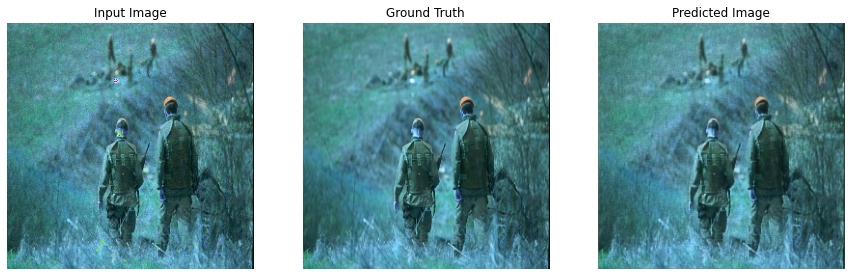

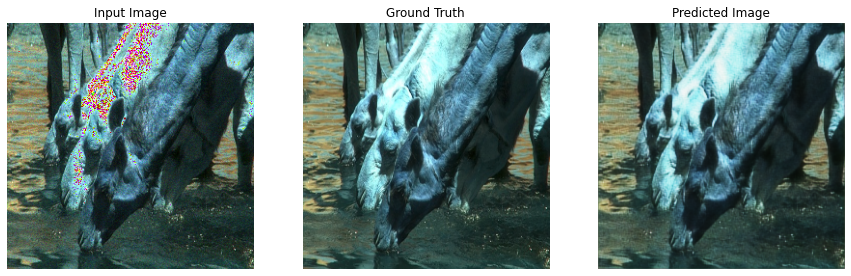

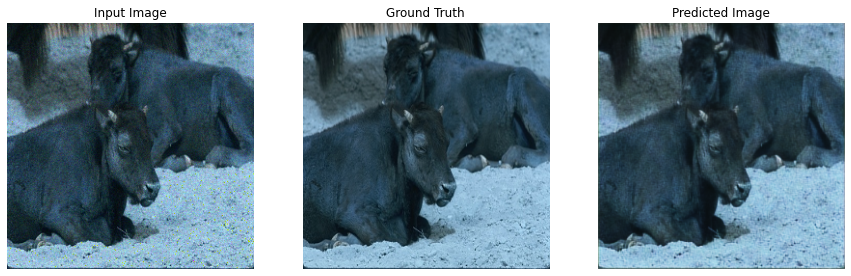

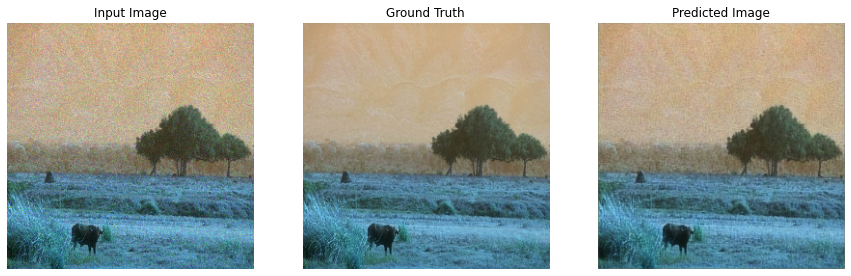

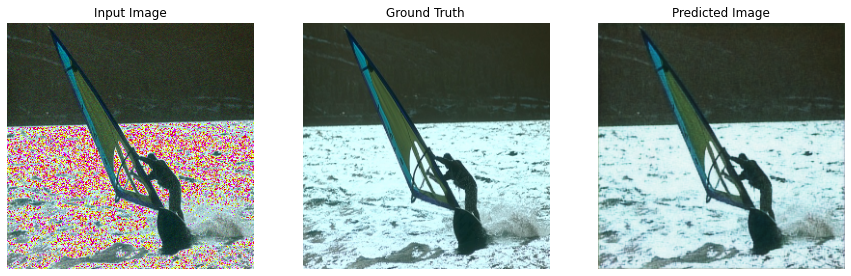

In [115]:
for inp, tar in test_dataset.take(5):
  generate_images(autoencoder, inp, tar)